In [1]:
from Func import Dissertation_Func_1D

In [2]:
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator, interp1d
from scipy.optimize import root_scalar

# -------- legend label for λ (same style as before) --------
def _lambda_label(val):
    if np.isclose(val, 1.0):  return "1"
    if np.isclose(val, 10.0): return "10"
    exp = int(np.round(np.log10(val)))
    return rf"$10^{{{exp}}}$"

# -------- front finder (spline, same logic as before) --------
def _front_location_at_time_spline(model, t_ref, threshold=0.5, band=(0.1, 0.9),
                                   spline_type='pchip', target='N'):
    x = model.x
    t_vec = model.times
    u_arr = model.N_arr if target.lower() == 'n' else model.M_arr

    idx = int(np.argmin(np.abs(t_vec - t_ref)))
    u = u_arr[idx]

    mask = (u > band[0]) & (u < band[1])
    if np.sum(mask) < 5:
        return None, idx

    x_local, u_local = x[mask], u[mask]
    sidx = np.argsort(x_local)
    x_local, u_local = x_local[sidx], u_local[sidx]

    st = spline_type.lower()
    if st == 'cubic':  spline = CubicSpline(x_local, u_local)
    elif st == 'pchip': spline = PchipInterpolator(x_local, u_local)
    elif st == 'akima': spline = Akima1DInterpolator(x_local, u_local)
    elif st == 'linear': spline = interp1d(x_local, u_local, kind='linear', fill_value="extrapolate")
    else: raise ValueError(f"Unsupported spline_type: {spline_type}")

    sign = np.sign(u_local - threshold)
    crossing_idx = np.where(sign[:-1] * sign[1:] < 0)[0]
    if len(crossing_idx) == 0:
        return None, idx
    i = int(crossing_idx[0])
    xl, xr = x_local[i], x_local[i+1]

    sol = root_scalar(lambda xv: spline(xv) - threshold, bracket=[xl, xr], method='brentq')
    if sol.converged:
        return sol.root, idx
    return None, idx

# -------- dual-view plot for Dissertation_Func_1D --------
def plot_func_dual_view(models, times_to_plot,
                        xi_zoom=(-2, 2), xi_wide=(-20, 20),
                        threshold=0.5, band=(0.1, 0.9), spline_type='pchip',
                        m0_val=None, alpha_val=None,
                        cmap_name="viridis",
                        title=r"Regeneration present ($\alpha>0$): Asymptotics vs Numerical Simulation",
                        asymptote_mode="per_model_logistic"):
    """
    Dual-panel figure (zoomed & wide) comparing simulation profiles (centered at the 0.5-front)
    against asymptotic predictions for the functional-source model.

    Parameters
    ----------
    models : list[Dissertation_Func_1D]
        Each must be solved and have attributes .x, .times, .N_arr, .k (λ), .alpha, .m0.
    times_to_plot : list[float]
        Times to overlay (e.g. [80] or [80, 120]).
    xi_zoom, xi_wide : tuple
        X-limits in travelling coordinate for left/right panels.
    asymptote_mode : {"per_model_logistic", "single_kpp", "none"}
        - "per_model_logistic": overlay U(ξ) = 1/(1+exp(ξ/c_i)) using each model’s estimated c_i (best for σ→∞ or σ→0).
        - "single_kpp": a single dashed KPP profile with c = 2√(m0(1−m0)) (mainly for α=0, λ→0 case).
        - "none": no asymptote overlay.
    """

    # infer common m0/alpha if not provided and all models share them
    if m0_val is None and len(models) > 0:
        m0_vals = [getattr(m, "m0", None) for m in models]
        if all(v is not None and np.isclose(v, m0_vals[0]) for v in m0_vals):
            m0_val = float(m0_vals[0])
    if alpha_val is None and len(models) > 0:
        a_vals = [getattr(m, "alpha", None) for m in models]
        if all(v is not None and np.isclose(v, a_vals[0]) for v in a_vals):
            alpha_val = float(a_vals[0])

    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i / max(1, len(models)-1)) for i in range(len(models))]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    axL, axR = axes
    legend_handles = []

    # if single KPP is requested and we know m0
    if asymptote_mode == "single_kpp" and m0_val is not None:
        c_kpp = 2.0 * np.sqrt(m0_val * (1.0 - m0_val))
        xiL = np.linspace(*xi_zoom, 600)
        xiR = np.linspace(*xi_wide, 600)
        U_kpp_L = 1.0 / (1.0 + np.exp(xiL / c_kpp))
        U_kpp_R = 1.0 / (1.0 + np.exp(xiR / c_kpp))
    else:
        c_kpp = None

    # --- plot each model ---
    for color, model in zip(colors, models):
        lam = float(getattr(model, "k"))
        # legend entry for λ (one per model/color)
        legend_handles.append(Line2D([0],[0], color=color, lw=2, label=_lambda_label(lam)))

        # estimate c for this model (used if per-model logistic)
        c_i, _, _ = model.estimate_wave_speed(threshold=threshold, band=band,
                                              spline_type=spline_type, plot=False, target='N')

        # simulation snapshots (centered at 0.5-front)
        for t_ref in times_to_plot:
            x0, k = _front_location_at_time_spline(model, t_ref, threshold=threshold,
                                                   band=band, spline_type=spline_type, target='N')
            if x0 is None:
                continue
            xi_centered = model.x - x0
            u = model.N_arr[k]
            axL.plot(xi_centered, u, color=color, ls='-.', lw=2, alpha=0.95)
            axR.plot(xi_centered, u, color=color, ls='-.', lw=2, alpha=0.95)

        # asymptote per model (logistic with that model’s c_i)
        if asymptote_mode == "per_model_logistic" and (c_i is not None):
            xiL = np.linspace(*xi_zoom, 600)
            xiR = np.linspace(*xi_wide, 600)
            U_L = 1.0 / (1.0 + np.exp(xiL / c_i))
            U_R = 1.0 / (1.0 + np.exp(xiR / c_i))
            axL.plot(xiL, U_L, ls=':', color=color, lw=2.5, alpha=0.95)
            axR.plot(xiR, U_R, ls=':', color=color, lw=2.5, alpha=0.95)

    # single KPP overlay (if chosen)
    if asymptote_mode == "single_kpp" and c_kpp is not None:
        axL.plot(np.linspace(*xi_zoom, 600), U_kpp_L, 'k:', lw=3, alpha=0.95)
        axR.plot(np.linspace(*xi_wide, 600), U_kpp_R, 'k:', lw=3, alpha=0.95)

    # axes + cosmetics
    for ax, (xmin, xmax) in zip((axL, axR), (xi_zoom, xi_wide)):
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(-0.05, 1.05)
        ax.set_xlabel(r"$\xi$", fontsize=18)
        ax.grid(True, which='both', alpha=0.6)
        ax.tick_params(axis='both', which='major', length=7, width=2, labelsize=15)
        ax.tick_params(axis='both', which='minor', length=4, width=1.5)
    axL.set_ylabel(r"$U$", fontsize=18)

    # titles and annotations
    fig.suptitle(title, fontsize=20, weight="bold", y=0.98)
    subtitle_parts = []
    if alpha_val is not None:
        subtitle_parts.append(rf"$\alpha={alpha_val}$")
    if m0_val is not None:
        subtitle_parts.append(rf"$m_0={m0_val}$")
    if subtitle_parts:
        fig.text(0.5, 0.92, ", ".join(subtitle_parts),
                 ha='center', va='top', fontsize=16)

    # legend outside on the right (only λ entries)
    axR.legend(handles=legend_handles, title=r"$\lambda$",
               fontsize=15, title_fontsize=16.5,
               loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

    fig.tight_layout(rect=[0.03, 0.06, 0.85, 0.94])
    plt.show()

[warn] The maximum number of mesh nodes is exceeded.
Estimated c = 0.455822,  Estimated S = 79.4512


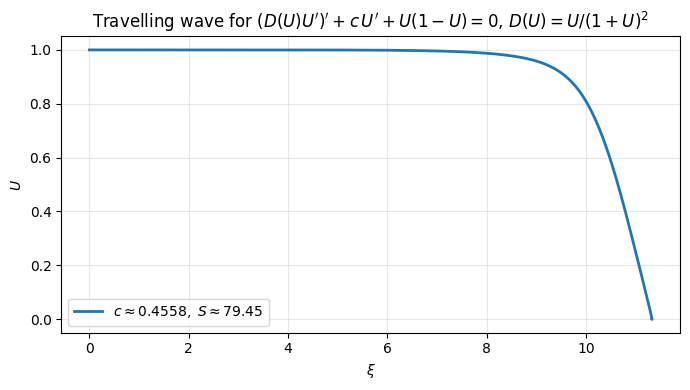

In [6]:
# Proper BVP with unknown wave speed c and unknown length S
# States: y = [U, Q]; Parameters: p = [c, S]
# ODE on tau in [0,1]:
#   dU/dtau = S * Q
#   dQ/dtau = S * (-c Q - U(1-U) D(U)),   D(U) = U / (1+U)^2
# BCs (4 conditions):
#   U(0) = 1 - epsL,  Q(0) = 0,  U(1) = epsR,  Q(1) = 0

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp, cumulative_trapezoid

def D(U):
    return U / (1.0 + U)**2

def ode_tau(tau, y, p):
    c, S = p
    U, Q = y
    fU = S * Q
    fQ = S * (-c * Q - U * (1.0 - U) * D(U))
    return np.vstack((fU, fQ))

def bc(ya, yb, p, epsL, epsR):
    # ya = y(0), yb = y(1)
    U0, Q0 = ya
    U1, Q1 = yb
    return np.array([
        U0 - (1.0 - epsL),   # U(0) = 1 - epsL
        Q0 - 0.0,            # Q(0) = 0
        U1 - epsR,           # U(1) = epsR
        Q1 - 0.0             # Q(1) = 0
    ])

def initial_guess(tau, k=8.0):
    # Tanh-like front located near tau~0.5
    z  = k * (tau - 0.5)
    U0 = 0.5 * (1.0 - np.tanh(z))
    Q0 = -0.5 * k / np.cosh(z)**2
    return np.vstack((U0, Q0))

def solve_front(epsL=1e-6, epsR=1e-4, tau_pts=400, c_guess=1.0, S_guess=40.0, tol=1e-5):
    tau = np.linspace(0.0, 1.0, tau_pts)
    y0  = initial_guess(tau, k=8.0)
    p0  = np.array([c_guess, S_guess])  # unknowns [c, S]

    sol = solve_bvp(
        fun=lambda t,y,p: ode_tau(t,y,p),
        bc=lambda ya,yb,p: bc(ya,yb,p,epsL,epsR),
        x=tau, y=y0, p=p0, tol=tol, max_nodes=200000
    )
    if sol.status != 0:
        print("[warn]", sol.message)
    return sol

def plot_solution(sol, show_xi=True):
    c, S = sol.p
    tau_plot = np.linspace(0.0, 1.0, 2000)
    U, Q = sol.sol(tau_plot)

    plt.figure(figsize=(7,4))
    if show_xi:
        # recover original ξ via dξ/ds = D(U), ds = S dτ ⇒ dξ/dτ = S D(U)
        xi = cumulative_trapezoid(S * D(U), tau_plot, initial=0.0)
        plt.plot(xi, U, lw=2, label=fr"$c\approx{c:.4g},\; S\approx{S:.4g}$")
        plt.xlabel(r"$\xi$")
    else:
        plt.plot(S * tau_plot, U, lw=2, label=fr"$c\approx{c:.4g},\; S\approx{S:.4g}$")
        plt.xlabel(r"$s$")
    plt.ylabel(r"$U$")
    plt.title(r"Travelling wave for $(D(U)U')' + c\,U' + U(1-U)=0$, $D(U)=U/(1+U)^2$")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

if __name__ == "__main__":
    sol = solve_front(epsL=1e-6, epsR=1e-4, c_guess=1.0, S_guess=50.0)
    print(f"Estimated c = {sol.p[0]:.6g},  Estimated S = {sol.p[1]:.6g}")
    plot_solution(sol, show_xi=True)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- model ---
def D(U):  # degenerate diffusion
    return U / (1.0 + U)**2

def rhs_flux(xi, y, c, delta):
    U, J = y
    Dd = D(U) + delta       # tiny regulariser to avoid D=0
    Uxi = J / Dd
    Jxi = - c * J / Dd - U * (1.0 - U)
    return [Uxi, Jxi]

def stop_at_tip(xi, y, epsR):
    return y[0] - epsR
stop_at_tip.terminal = True
stop_at_tip.direction = -1  # stop when U decreases to epsR

# --- run once for a clean front ---
c     = 1.0       # wave speed
L     = 60.0      # integrate from xi=-L toward +∞
epsL  = 1e-6      # U(-L) = 1 - epsL
epsR  = 1e-6      # stop when U ~ epsR
delta = 1e-8      # regularize D near U=0

U0   = 1.0 - epsL
U0p  = -(1.0/c) * U0 * (1.0 - U0)  # logistic left-tail slope
J0   = (D(U0) + delta) * U0p
y0   = [U0, J0]

sol = solve_ivp(
    fun=lambda x, y: rhs_flux(x, y, c=c, delta=delta),
    t_span=(-L, L),
    y0=y0,
    method="RK45",
    max_step=0.1,
    events=lambda x, y: stop_at_tip(x, y, epsR),
    rtol=1e-7, atol=1e-9
)

xi = sol.t
U  = sol.y[0]

# optional: logistic overlay for visual check (aligned at U=1/2)
i0 = np.argmin(np.abs(U - 0.5))
x0 = xi[i0]
U_log = 1.0 / (1.0 + np.exp((xi - x0) / c))

plt.figure(figsize=(7,4))
plt.plot(xi, U, lw=2, label="Travelling wave (IVP, flux)")
plt.plot(xi, U_log, "k--", lw=1.8, label="Reference logistic (aligned)")
plt.xlim([xi.min(), xi.max()]); plt.ylim([-0.02, 1.02])
plt.xlabel(r"$\xi$"); plt.ylabel(r"$U(\xi)$")
plt.title(r"$((U/(1+U)^2)\,U')' + c\,U' + U(1-U)=0$  — monotone front")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

KeyboardInterrupt: 

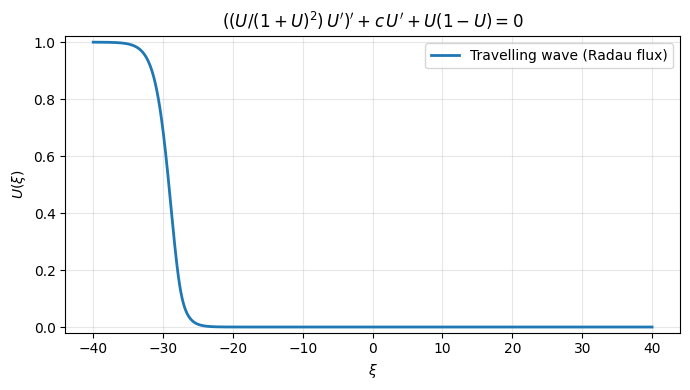

In [11]:
# fast_wave.py — Travelling wave for ((U/(1+U)^2) U')' + c U' + U(1-U) = 0
# Method 1: IVP in flux form, stiff solver (Radau) with Jacobian

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ----- diffusion -----
def D(U):
    return U / (1.0 + U)**2

# ----- ODE in flux form -----
def rhs(xi, y, c, delta):
    U, J = y
    Dd = D(U) + delta  # regularise denominator
    Uxi = J / Dd
    Jxi = -c * J / Dd - U * (1.0 - U)
    return [Uxi, Jxi]

# Jacobian of rhs wrt y
def jac(xi, y, c, delta):
    U, J = y
    DU = D(U) + delta
    dD = (1.0 - U) / (1.0 + U)**3
    # derivatives
    df1dU = -J * dD / (DU * DU)
    df1dJ = 1.0 / DU
    df2dU = (c*J * dD) / (DU*DU) - (1 - 2*U)
    df2dJ = -c / DU
    return np.array([[df1dU, df1dJ],
                     [df2dU, df2dJ]])

# Stop condition: wave tip (U ≈ epsR)
def stop_at_tip(x, y, epsR):
    return y[0] - epsR
stop_at_tip.terminal = True
stop_at_tip.direction = -1

# ----- driver -----
def fast_wave(c=1.0, L=40.0, epsL=1e-4, epsR=1e-4, delta=1e-8):
    # initial state near left tail
    U0  = 1.0 - epsL
    U0p = -(1.0/c) * U0 * (1.0 - U0)   # logistic slope approximation
    J0  = (D(U0) + delta) * U0p
    y0  = [U0, J0]

    sol = solve_ivp(
        fun=lambda x, y: rhs(x, y, c, delta),
        t_span=(-L, L),
        y0=y0,
        method="Radau",                    # stiff solver
        jac=lambda x, y: jac(x, y, c, delta),
        rtol=1e-7, atol=1e-9,
        max_step=0.5,
        events=lambda x, y: stop_at_tip(x, y, epsR)
    )
    return sol.t, sol.y[0]

# ----- run & plot -----
if __name__ == "__main__":
    xi, U = fast_wave(c=1.0, L=40.0, epsL=1e-4, epsR=1e-4, delta=1e-8)

    plt.figure(figsize=(7,4))
    plt.plot(xi, U, lw=2, label="Travelling wave (Radau flux)")
    plt.xlabel(r"$\xi$"); plt.ylabel(r"$U(\xi)$")
    plt.title(r"$((U/(1+U)^2)\,U')' + c\,U' + U(1-U)=0$")
    plt.ylim([-0.02,1.02]); plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()

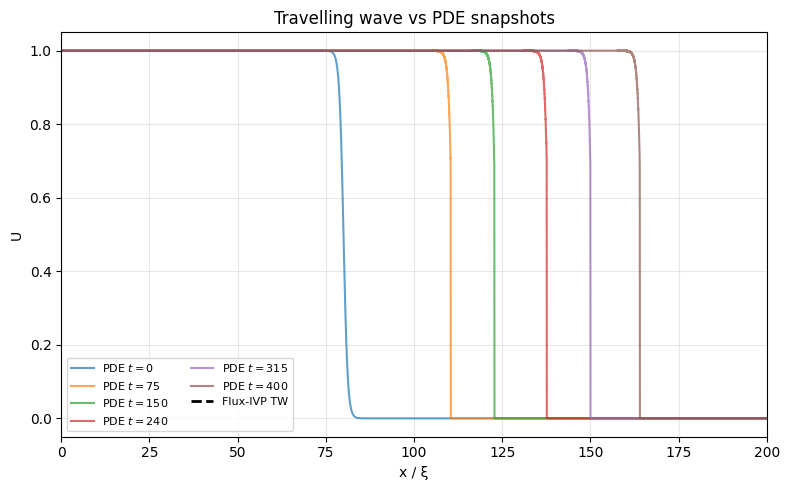

In [12]:
# compare_wave.py — overlay PDE snapshots with flux-IVP travelling wave

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.integrate import solve_ivp

# ---- flux-IVP solver (Method 1) ----
def D(U): return U/(1+U)**2
def rhs(xi, y, c, delta):
    U, J = y
    Dd = D(U) + delta
    return [J/Dd, -c*J/Dd - U*(1-U)]
def jac(xi, y, c, delta):
    U, J = y; DU = D(U)+delta; dD = (1-U)/(1+U)**3
    return np.array([[-J*dD/(DU*DU), 1.0/DU],
                     [ (c*J*dD)/(DU*DU) - (1-2*U), -c/DU]])
def stop_at_tip(x,y,epsR): return y[0]-epsR
stop_at_tip.terminal=True; stop_at_tip.direction=-1
def fast_wave(c=1.0,L=40.0,epsL=1e-4,epsR=1e-4,delta=1e-8):
    U0=1-epsL; U0p=-(1/c)*U0*(1-U0); J0=(D(U0)+delta)*U0p
    sol=solve_ivp(lambda x,y: rhs(x,y,c,delta),(-L,L),[U0,J0],
                  method="Radau",jac=lambda x,y: jac(x,y,c,delta),
                  rtol=1e-7,atol=1e-9,max_step=0.5,
                  events=lambda x,y: stop_at_tip(x,y,epsR))
    return sol.t, sol.y[0]

# ---- load PDE simulation ----
base = Path("/Users/chamundeshwarivadamalai/Desktop/Oxford/Dissertation/Main/Dissertation_main/New/Dissertation/Graphs_new/Func/speeds_func_l/lambda_100000000/alpha_100000000/m0_0.4")
snap_file = base / "snapshots.npz"
dat = np.load(snap_file)

x      = dat["x"]          # spatial grid (length N)
times  = dat["times"]      # array of snapshot times
N_arr  = dat["N_arr"]      # shape (nt, N) — PDE solution

# ---- choose which snapshots to plot ----
idxs = np.linspace(0, len(times)-1, 6, dtype=int)  # pick ~6 evenly spaced
snap_times = times[idxs]
snapshots  = N_arr[idxs,:]

# ---- flux-IVP wave ----
xi, U = fast_wave(c=0.16493187560549494, L=200, epsL=1e-4, epsR=1e-4, delta=1e-8)

# ---- plot ----
plt.figure(figsize=(8,5))
# PDE snapshots
for t,u in zip(snap_times,snapshots):
    plt.plot(x,u,lw=1.5,alpha=0.7,label=fr"PDE $t={t:.0f}$")
# flux-IVP solution
plt.plot(xi,U,"k--",lw=2.0,label="Flux-IVP TW")
plt.xlim([0,200]); plt.ylim([-0.05,1.05])
plt.xlabel("x / ξ"); plt.ylabel("U")
plt.title("Travelling wave vs PDE snapshots")
plt.grid(True,alpha=0.3); plt.legend(ncol=2,fontsize=8)
plt.tight_layout(); plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator, interp1d
from scipy.optimize import root_scalar
from scipy.integrate import solve_ivp

# ===============================
# 1) Front locator (unchanged)
# ===============================
def front_location_at_time_spline(model, t_ref, threshold=0.5, band=(0.1, 0.9),
                                  spline_type='cubic', target='N'):
    x = model.x
    t_vec = model.times
    u_arr = model.N_arr if target.lower() == 'n' else model.M_arr

    idx = int(np.argmin(np.abs(t_vec - t_ref)))
    u = u_arr[idx]

    mask = (u > band[0]) & (u < band[1])
    if np.sum(mask) < 5:
        return None, idx

    x_local, u_local = x[mask], u[mask]
    sort_idx = np.argsort(x_local)
    x_local, u_local = x_local[sort_idx], u_local[sort_idx]

    st = spline_type.lower()
    if st == 'cubic':
        spline = CubicSpline(x_local, u_local)
    elif st == 'pchip':
        spline = PchipInterpolator(x_local, u_local)
    elif st == 'akima':
        spline = Akima1DInterpolator(x_local, u_local)
    elif st == 'linear':
        spline = interp1d(x_local, u_local, kind='linear', fill_value="extrapolate")
    else:
        raise ValueError(f"Unsupported spline_type: {spline_type}")

    sign = np.sign(u_local - threshold)
    crossing_idx = np.where(sign[:-1] * sign[1:] < 0)[0]
    if len(crossing_idx) == 0:
        return None, idx

    i = crossing_idx[0]
    x_left, x_right = x_local[i], x_local[i + 1]

    sol = root_scalar(lambda xv: spline(xv) - threshold, bracket=[x_left, x_right], method='brentq')
    if sol.converged:
        return sol.root, idx
    return None, idx

# ===============================
# 2) Labels
# ===============================
def _lambda_label(val):
    if np.isclose(val, 1.0):  return "1"
    if np.isclose(val, 10.0): return "10"
    exp = int(np.round(np.log10(val)))
    return rf"$10^{{{exp}}}$"

# ===============================
# 3) Flux-IVP wave (weird eqn)
#     ((U/(1+U)^2) U')' + c U' + U(1-U) = 0
# ===============================
def _D(U):  # degenerate diffusion
    return U / (1.0 + U)**2

def _rhs_flux(xi, y, c, delta):
    U, J = y
    Dd = _D(U) + delta
    Uxi = J / Dd
    Jxi = -c * J / Dd - U * (1.0 - U)
    return [Uxi, Jxi]

def _jac_flux(xi, y, c, delta):
    U, J = y
    DU = _D(U) + delta
    dD = (1.0 - U) / (1.0 + U)**3
    df1dU = -J * dD / (DU * DU)
    df1dJ =  1.0 / DU
    df2dU = (c*J * dD) / (DU * DU) - (1.0 - 2.0*U)
    df2dJ = -c / DU
    return np.array([[df1dU, df1dJ],
                     [df2dU, df2dJ]])

def _stop_at_tip(x, y, epsR):
    return y[0] - epsR
_stop_at_tip.terminal = True
_stop_at_tip.direction = -1

def compute_flux_wave(c, L=60.0, epsL=1e-4, epsR=1e-4, delta=1e-8,
                      rtol=1e-7, atol=1e-9, max_step=0.5):
    """Return (xi, U) for the flux-IVP travelling wave at speed c."""
    U0  = 1.0 - epsL
    U0p = -(1.0/c) * U0 * (1.0 - U0)   # logistic left-tail slope (good seed)
    J0  = (_D(U0) + delta) * U0p
    y0  = [U0, J0]

    sol = solve_ivp(
        fun=lambda x, y: _rhs_flux(x, y, c, delta),
        t_span=(-L, L),
        y0=y0,
        method="Radau",
        jac=lambda x, y: _jac_flux(x, y, c, delta),
        rtol=rtol, atol=atol, max_step=max_step,
        events=lambda x, y: _stop_at_tip(x, y, epsR)
    )
    return sol.t, sol.y[0]

def _x_at_half(x, u):
    """Return x where u(x)=0.5 (monotone front); flips if needed."""
    if u[0] < u[-1]:
        x_use = x[::-1]; u_use = u[::-1]
    else:
        x_use = x;       u_use = u
    f = interp1d(u_use, x_use, bounds_error=False, fill_value="extrapolate")
    return float(f(0.5))

# ===============================
# 4) Main: plot weird-eqn TW vs centred snapshots
# ===============================
def plot_weird_eqn_vs_numerics(models, times_to_plot,
                               xi_limits=None, window_factor=8.0,
                               threshold=0.5, band=(0.1, 0.9), spline_type='pchip',
                               title=r"Flux–IVP Travelling Wave vs Numerical Simulation",
                               m0_val=None, cmap_name="plasma",
                               L_flux=60.0, epsL_flux=1e-4, epsR_flux=1e-4, delta_flux=1e-8):
    """
    For each model:
      - estimate speed c_hat (your method)
      - compute flux-IVP wave (xi_flux, U_flux)
      - center each PDE snapshot by its U=0.5 location (xi = x - x0(t))
      - plot snapshots and an aligned dashed flux curve for each snapshot
    """
    # infer m0 for subtitle if not provided and consistent
    if m0_val is None and len(models) > 0:
        m0_vals = [getattr(m, "m0", None) for m in models]
        if all(v is not None and np.isclose(v, m0_vals[0]) for v in m0_vals):
            m0_val = float(m0_vals[0])

    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i / max(1, len(models)-1)) for i in range(len(models))]

    fig, ax = plt.subplots(figsize=(9, 6))
    legend_handles = []
    final_xlim = None

    for color, model in zip(colors, models):
        lam = float(getattr(model, "k"))
        # estimate c from this run (your existing estimator)
        c_hat, _, _ = model.estimate_wave_speed(threshold=threshold, band=band,
                                                spline_type=spline_type, plot=False, target='N')

        # xi window for display
        if xi_limits is None:
            w = float(window_factor) * float(c_hat)
            xi_min, xi_max = -w, w
        else:
            xi_min, xi_max = float(xi_limits[0]), float(xi_limits[1])
        final_xlim = (xi_min, xi_max)

        # ---- flux-IVP wave for this c_hat ----
        xi_flux, U_flux = compute_flux_wave(c_hat, L=L_flux, epsL=epsL_flux, epsR=epsR_flux, delta=delta_flux)
        xi0_flux = _x_at_half(xi_flux, U_flux)  # 0.5 crossing of flux profile

        # ---- plot centred PDE snapshots + aligned flux (dashed) ----
        added_handle = False
        for t_ref in times_to_plot:
            x0, idx = front_location_at_time_spline(model, t_ref, threshold=threshold,
                                                    band=band, spline_type=spline_type, target='N')
            if x0 is None:
                continue
            xi_centered = model.x - x0
            u = model.N_arr[idx]
            ax.plot(xi_centered, u, color=color, lw=2, alpha=0.9)

            # Align flux: shift so its 0.5 matches this snapshot's 0.5 (which is at xi=0 after centering)
            x_flux_aligned = xi_flux - xi0_flux  # so that 0.5 is at 0
            ax.plot(x_flux_aligned, U_flux, ls='--', color=color, lw=2, alpha=1.0)

            if not added_handle:
                legend_handles.append(Line2D([0],[0], color=color, lw=2, label=_lambda_label(lam)))
                added_handle = True

    # axes, labels, titles
    if final_xlim is not None:
        ax.set_xlim(*final_xlim)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel(r"$\xi$", fontsize=18)
    ax.set_ylabel(r"$U$", fontsize=18)
    ax.set_title(title, fontsize=19, weight="bold", y=1.09)
    if m0_val is not None:
        fig.suptitle(rf"$m_0={m0_val}$", fontsize=18, y=0.85)

    # λ legend outside
    ax.legend(handles=legend_handles, title=r"$\lambda$",
              fontsize=15, title_fontsize=16.5,
              loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

    ax.grid(True)
    ax.tick_params(axis='both', which='major', length=7, width=2, labelsize=15)
    ax.tick_params(axis='both', which='minor', length=4, width=1.5)
    fig.tight_layout()
    plt.show()

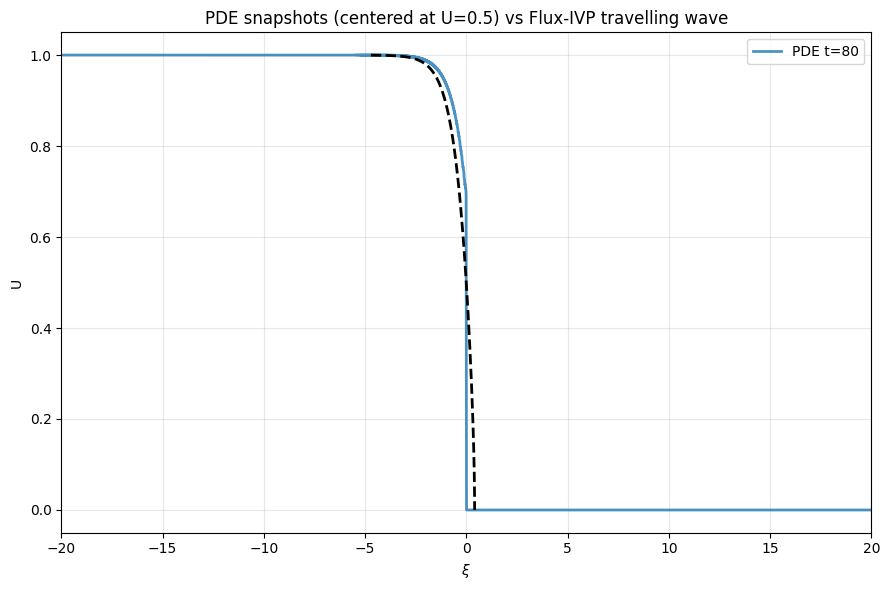

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator, interp1d
from scipy.optimize import root_scalar
from scipy.integrate import solve_ivp

# ========= Load PDE data =========
dat = np.load("/Users/chamundeshwarivadamalai/Desktop/Oxford/Dissertation/Main/Dissertation_main/New/Dissertation/Graphs_new/Func/speeds_func_l/lambda_100000000/alpha_100000000/m0_0.4/snapshots.npz")
x      = dat["x"]
times  = dat["times"]
N_arr  = dat["N_arr"]   # shape (nt, N)

# ========= Front locator (same as before) =========
def front_location_at_time_spline(x, times, N_arr, t_ref, threshold=0.5, band=(0.1,0.9),
                                  spline_type='pchip'):
    idx = int(np.argmin(np.abs(times - t_ref)))
    u = N_arr[idx]

    mask = (u > band[0]) & (u < band[1])
    if np.sum(mask) < 5:
        return None, idx

    x_local, u_local = x[mask], u[mask]
    sort_idx = np.argsort(x_local)
    x_local, u_local = x_local[sort_idx], u_local[sort_idx]

    st = spline_type.lower()
    if st == 'cubic': spline = CubicSpline(x_local, u_local)
    elif st == 'pchip': spline = PchipInterpolator(x_local, u_local)
    elif st == 'akima': spline = Akima1DInterpolator(x_local, u_local)
    else: spline = interp1d(x_local, u_local, kind='linear')

    sign = np.sign(u_local - threshold)
    crossing_idx = np.where(sign[:-1]*sign[1:] < 0)[0]
    if len(crossing_idx)==0: return None, idx

    i = crossing_idx[0]
    x_left, x_right = x_local[i], x_local[i+1]
    sol = root_scalar(lambda xv: spline(xv) - threshold,
                      bracket=[x_left,x_right], method='brentq')
    if sol.converged: return sol.root, idx
    return None, idx

# ========= Flux-IVP wave (weird eqn) =========
def D(U): return U/(1+U)**2
def rhs_flux(xi,y,c,delta):
    U,J = y; Dd = D(U)+delta
    return [J/Dd, -c*J/Dd - U*(1-U)]
def jac_flux(xi,y,c,delta):
    U,J=y; DU=D(U)+delta; dD=(1-U)/(1+U)**3
    return np.array([[-J*dD/(DU*DU), 1.0/DU],
                     [(c*J*dD)/(DU*DU) - (1-2*U), -c/DU]])
def stop_at_tip(x,y,epsR): return y[0]-epsR
stop_at_tip.terminal=True; stop_at_tip.direction=-1

def compute_flux_wave(c,L=200,epsL=1e-4,epsR=1e-4,delta=1e-8):
    U0=1-epsL; U0p=-(1/c)*U0*(1-U0); J0=(D(U0)+delta)*U0p
    sol=solve_ivp(lambda x,y: rhs_flux(x,y,c,delta),
                  (-L,L), [U0,J0], method="Radau",
                  jac=lambda x,y: jac_flux(x,y,c,delta),
                  rtol=1e-7, atol=1e-9, max_step=0.5,
                  events=lambda x,y: stop_at_tip(x,y,epsR))
    return sol.t, sol.y[0]

def x_at_half(x,u):
    if u[0]<u[-1]: x,u=x[::-1],u[::-1]
    f=interp1d(u,x, bounds_error=False, fill_value="extrapolate")
    return float(f(0.5))

# ========= Run comparison =========
# your metadata says speed ≈ 0.1649
c_speed = 0.16493187560549494
xi_flux,U_flux = compute_flux_wave(c_speed,L=200)
xi0_flux = x_at_half(xi_flux,U_flux)

# pick snapshot times
times_to_plot = [80]

plt.figure(figsize=(9,6))
for t_ref in times_to_plot:
    x0,idx = front_location_at_time_spline(x,times,N_arr,t_ref,threshold=0.5)
    if x0 is None: continue
    xi_centered = x - x0
    u = N_arr[idx]
    plt.plot(xi_centered,u,lw=2,alpha=0.8,label=f"PDE t={t_ref}")

    # align flux wave so U=0.5 is at 0
    x_flux_aligned = xi_flux - xi0_flux
    plt.plot(x_flux_aligned,U_flux,"k--",lw=2)

plt.xlim([-20,20]); plt.ylim([-0.05,1.05])
plt.xlabel(r"$\xi$"); plt.ylabel("U")
plt.title("PDE snapshots (centered at U=0.5) vs Flux-IVP travelling wave")
plt.legend(); plt.grid(True,alpha=0.3); plt.tight_layout()
plt.show()

Using wave speed c = 0.16493188


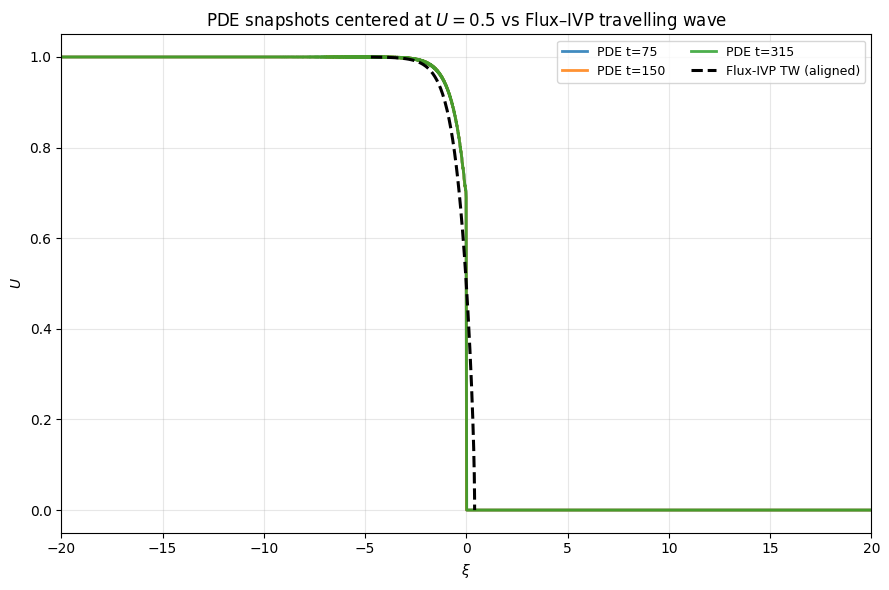

In [21]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator, interp1d
from scipy.optimize import root_scalar
from scipy.integrate import solve_ivp
from scipy.stats import linregress

# ---------- CONFIG ----------
base = Path("/Users/chamundeshwarivadamalai/Desktop/Oxford/Dissertation/Main/Dissertation_main/New/Dissertation/Graphs_new/Func/speeds_func_l/lambda_100000000/alpha_100000000/m0_0.4")
snap_file = base / "snapshots.npz"       # required
fronts_candidates = [base/"fronts.npz", base/"fronts_N.npz"]
summary_file = base / "summary.json"     # optional
times_to_plot = [0, 75, 150, 240, 315, 400]
spline_type = "pchip"
threshold = 0.5
band = (0.1, 0.9)

# ---------- Load PDE data ----------
dat = np.load(snap_file)
x = dat["x"]; times = dat["times"]; N_arr = dat["N_arr"]

# ---------- Front locator (same as your style) ----------
def front_location_at_time_spline(x, times, N_arr, t_ref, threshold=0.5, band=(0.1,0.9), spline_type='pchip'):
    idx = int(np.argmin(np.abs(times - t_ref)))
    u = N_arr[idx]
    mask = (u > band[0]) & (u < band[1])
    if np.sum(mask) < 5: return None, idx
    x_local, u_local = x[mask], u[mask]
    srt = np.argsort(x_local); x_local, u_local = x_local[srt], u_local[srt]

    st = spline_type.lower()
    if st == 'cubic':  spline = CubicSpline(x_local, u_local)
    elif st == 'pchip': spline = PchipInterpolator(x_local, u_local)
    elif st == 'akima': spline = Akima1DInterpolator(x_local, u_local)
    else:              spline = interp1d(x_local, u_local, kind='linear', fill_value="extrapolate")

    sign = np.sign(u_local - threshold)
    idxs = np.where(sign[:-1]*sign[1:] < 0)[0]
    if len(idxs) == 0: return None, idx
    i = idxs[0]; a, b = x_local[i], x_local[i+1]
    sol = root_scalar(lambda xv: spline(xv) - threshold, bracket=[a,b], method='brentq')
    return (sol.root if sol.converged else None), idx

# ---------- Get wave speed from files (summary.json → fronts.npz → estimate) ----------
def get_wave_speed():
    # 1) summary.json
    if summary_file.exists():
        try:
            with open(summary_file, "r") as f:
                meta = json.load(f)
            if "wave_speed" in meta and np.isfinite(meta["wave_speed"]):
                return float(meta["wave_speed"])
        except Exception:
            pass
    # 2) fronts.npz / fronts_N.npz
    for f in fronts_candidates:
        if f.exists():
            try:
                fr = np.load(f)
                t = fr["t_fronts"]; xf = fr["x_fronts"]
                slope = linregress(t, xf).slope
                if np.isfinite(slope): return float(slope)
            except Exception:
                continue
    # 3) estimate from snapshots directly
    #    pick 20 evenly spaced times across the interior
    idxs = np.linspace(0, len(times)-1, 20, dtype=int)
    t_sel, x_sel = [], []
    for i in idxs:
        x0, _ = front_location_at_time_spline(x, times, N_arr, times[i],
                                              threshold=threshold, band=band, spline_type=spline_type)
        if x0 is not None:
            t_sel.append(times[i]); x_sel.append(x0)
    if len(t_sel) >= 5:
        slope = linregress(t_sel, x_sel).slope
        return float(slope)
    raise RuntimeError("Could not determine wave speed from files or snapshots.")

c_speed = get_wave_speed()
print(f"Using wave speed c = {c_speed:.8g}")

# ---------- Flux-IVP wave (weird eqn) ----------
def D(U): return U/(1.0+U)**2
def rhs_flux(xi,y,c,delta):
    U,J=y; Dd=D(U)+delta
    return [J/Dd, -c*J/Dd - U*(1-U)]
def jac_flux(xi,y,c,delta):
    U,J=y; DU=D(U)+delta; dD=(1-U)/(1+U)**3
    return np.array([[-J*dD/(DU*DU), 1.0/DU],
                     [(c*J*dD)/(DU*DU) - (1-2*U), -c/DU]])
def stop_at_tip(x,y,epsR): return y[0]-epsR
stop_at_tip.terminal=True; stop_at_tip.direction=-1

def compute_flux_wave(c, L=200.0, epsL=1e-4, epsR=1e-4, delta=1e-8,
                      rtol=1e-7, atol=1e-9, max_step=0.5):
    U0=1-epsL; U0p=-(1.0/c)*U0*(1.0-U0); J0=(D(U0)+delta)*U0p
    sol=solve_ivp(lambda x,y: rhs_flux(x,y,c,delta), (-L,L), [U0,J0],
                  method="Radau", jac=lambda x,y: jac_flux(x,y,c,delta),
                  rtol=rtol, atol=atol, max_step=max_step,
                  events=lambda x,y: stop_at_tip(x,y,epsR))
    return sol.t, sol.y[0]

def x_at_half(x,u):
    if u[0] < u[-1]: x,u = x[::-1], u[::-1]
    f = interp1d(u, x, bounds_error=False, fill_value="extrapolate")
    return float(f(0.5))

# Compute flux wave at detected speed and align at U=0.5
xi_flux, U_flux = compute_flux_wave(c_speed, L=200.0)
xi0_flux = x_at_half(xi_flux, U_flux)
x_flux_aligned = xi_flux - xi0_flux   # so U=0.5 occurs at 0

# ---------- Plot centered snapshots + aligned flux ----------
plt.figure(figsize=(9,6))
for t_ref in times_to_plot:
    x0, idx = front_location_at_time_spline(x, times, N_arr, t_ref,
                                            threshold=threshold, band=band, spline_type=spline_type)
    if x0 is None: continue
    xi_centered = x - x0
    u = N_arr[idx]
    plt.plot(xi_centered, u, lw=2, alpha=0.85, label=f"PDE t={t_ref}")

plt.plot(x_flux_aligned, U_flux, "k--", lw=2.2, label="Flux-IVP TW (aligned)")
plt.xlim([-20, 20]); plt.ylim([-0.05, 1.05])
plt.xlabel(r"$\xi$"); plt.ylabel(r"$U$")
plt.title("PDE snapshots centered at $U=0.5$ vs Flux–IVP travelling wave")
plt.grid(True, alpha=0.3); plt.legend(ncol=2, fontsize=9)
plt.tight_layout(); plt.show()